# 19.1 A replication crisis?

**2024/4/30 闫晴宜、林海欣  
分工情况：各自完成代码和讨论问题，整合展示**

## replication crisis
Campbell Harvey: “at least half of the 400 supposedly market-beating strategies identified in top financial journals over the years are bogus.”<br>
追求p值（p-hacking）: search for “significant” and “positive” results<br>
Harvey (2017) : 90% of published studies report such “significant” and “positive” results.<br>

### Simmons et al. (2011) ：
认为研究者在实验过程中有较高的自主性（researcher degrees of freedom），可以选择不同的样本大小、数据、控制变量、假设条件、研究方法……<br>
这样的自由度通常会导致file-drawer problem，即不“成立”的假设不会被展示<br>
作者设计了两组实验，发现数据收集过程的自主性会导致假阳性率大幅上升，认为研究者会通过故意操纵样本选择、数据收集等过程，来证明自己的假设成立<br>
第二组实验中，作者设计了一个随机样本，每个观测变量都服从正态分布，并观察至少有一个p值低于显著性水平的频率，结果如Table 1.Likelihood of Obtaining a False-Positive Result所示<br>

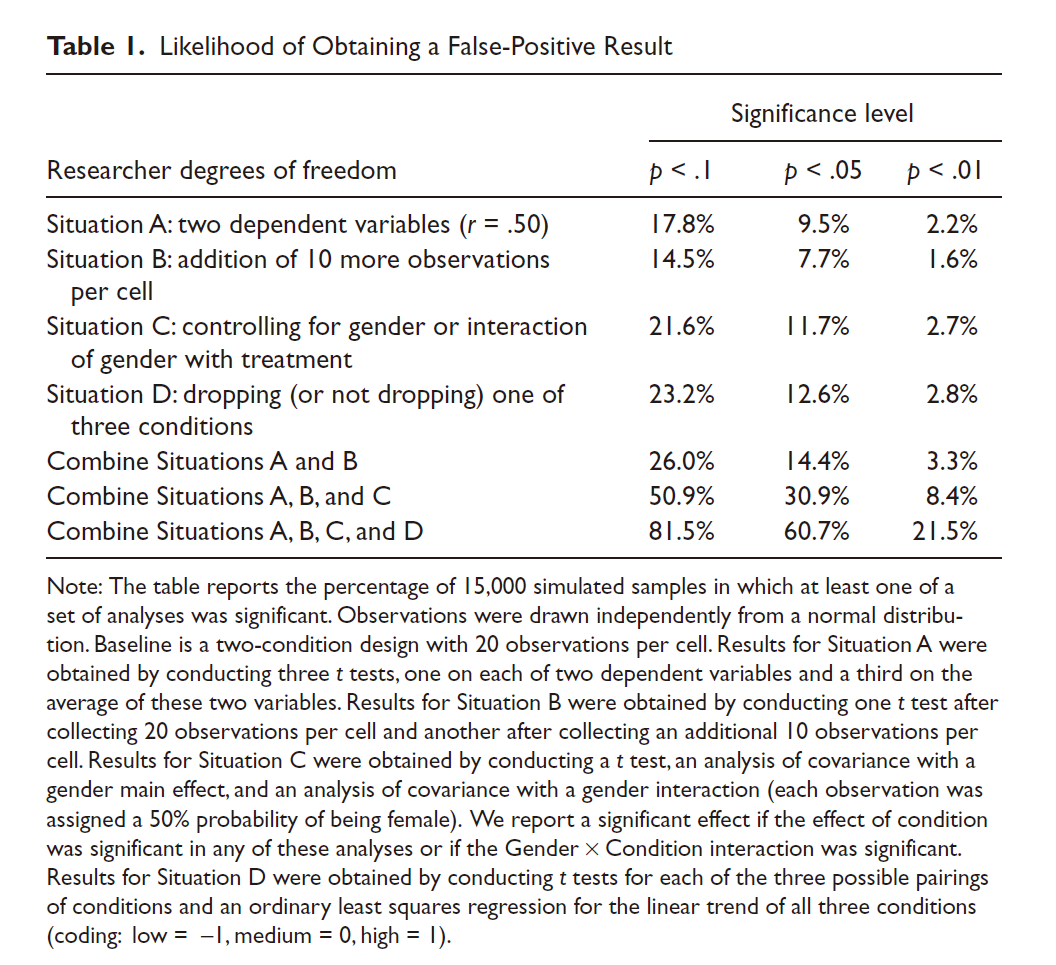

### Bloomfield et al. (2018)：
发现经过JAR会议检验的文章结论强于未经检验的文章
- Journal of Accounting Research (JAR)：a Registration-based Editorial Process (REP)<br>
- 在REP的要求下，研究者需要明晰收集和分析数据的过程。JAR会向评论者发送文章、保密协议，并收集建议反馈给作者，作者将按照建议反复更改研究<br>

HARKing (from “Hypothesizing After Results are Known”)：寻找“显著的”相关性，再形成预测假设

Tyler Vigen：https://tylervigen.com/spurious-correlations<br>
展示了多个虚假的因果关系，但有创意的学术研究能把故事讲好

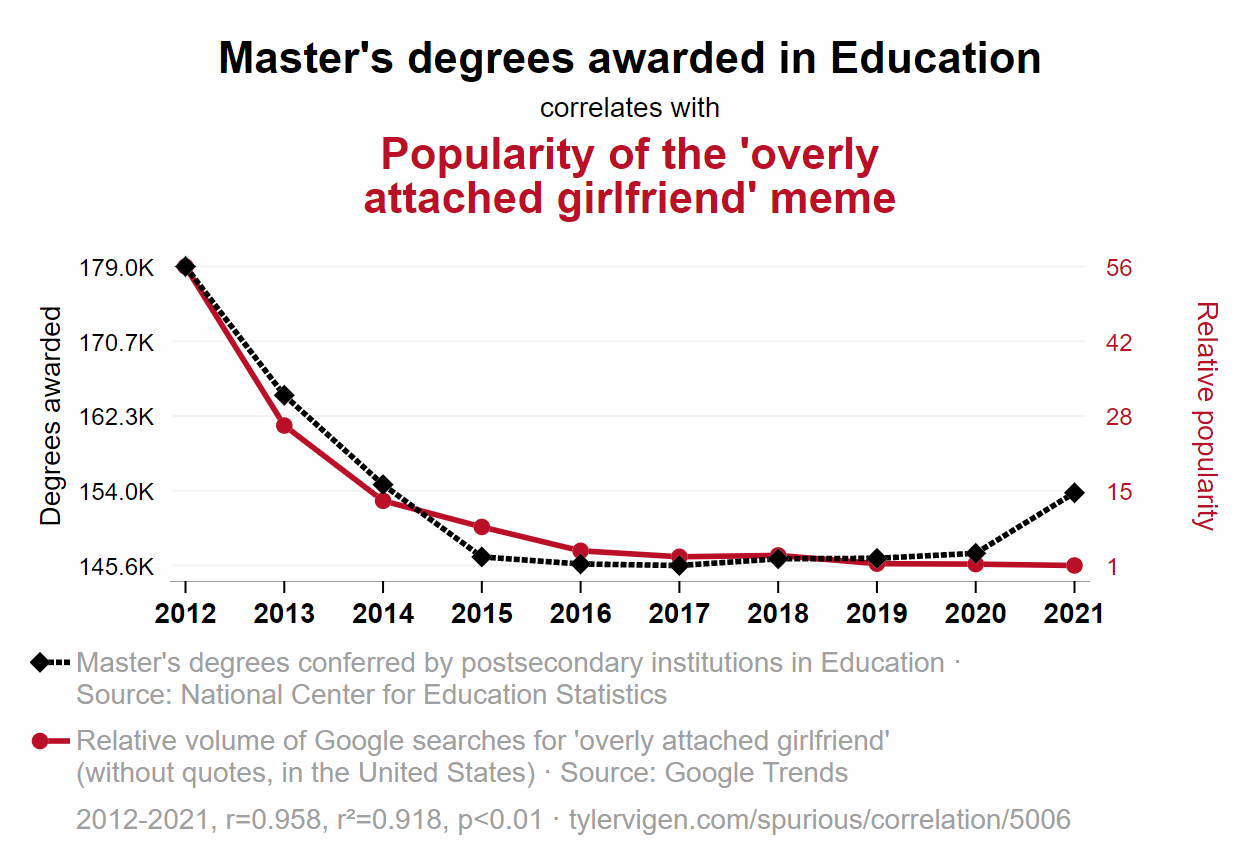

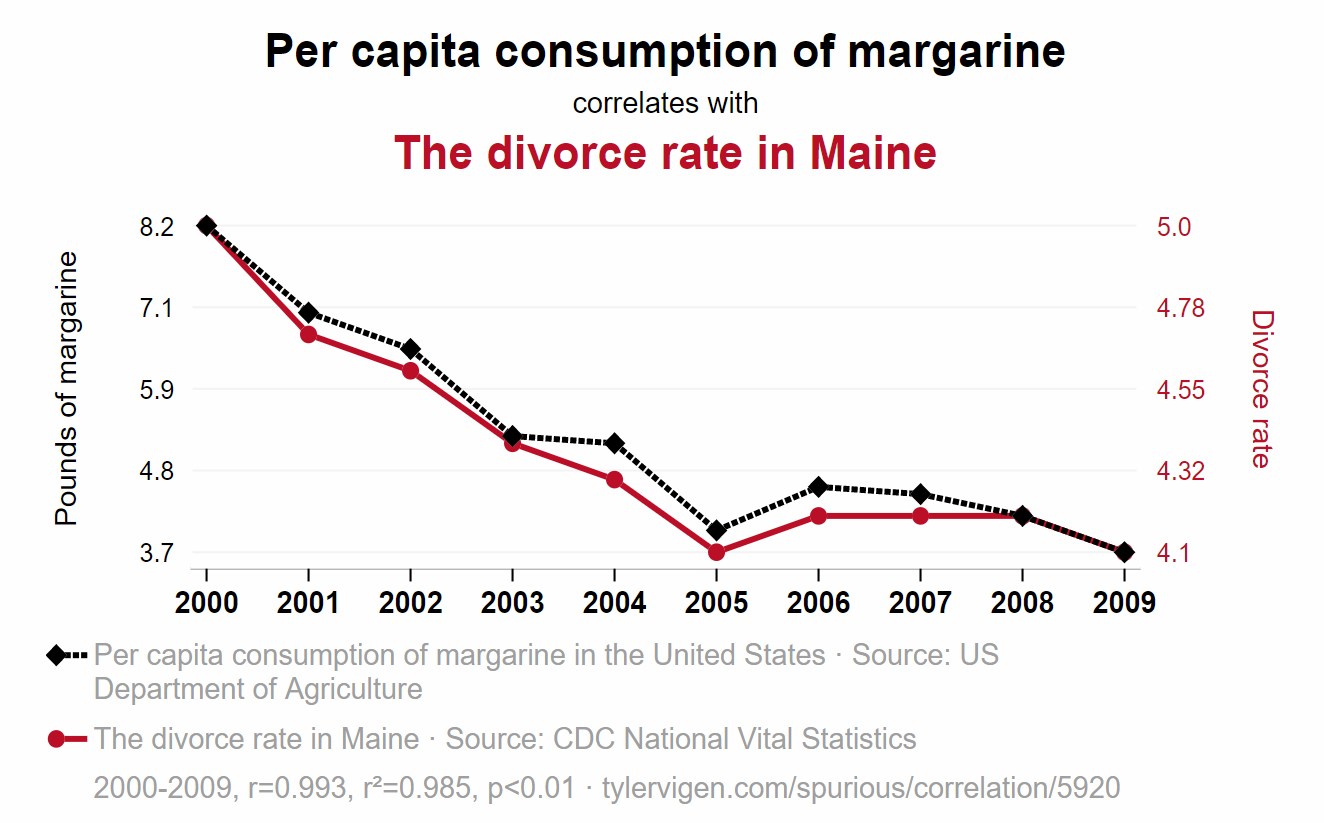

## 19.2 The Reg SHO experiment

Regulation SHO：a regulation governing short-selling activities in equity markets<br>主要目的是为了防止部分做空行为干扰市场，<br>
SHO 条例要求在连续五个结算日发生以下情况时报告：<br>
- 总计未能在注册清算机构交付每只证券 10,000 股或更多股。<br>
- 失败的数量至少等于发行的已发行总股份的百分之一的二分之一。<br>
- 证券包含在自律组织 (SRO) 发布的清单中。<br>
<br>
制定了“Locate”和“Close-out”两条针对做空的条例：<br>
a. Locate（“定位”）：任何经纪人保证，在借出交易发生之时，其手中确实拥有对应公司的足够数量股票，要求经纪人有合理的理由相信被卖空的股票可以借入和交付在卖空发生之前的特定日期。<br>
b. Close-out（“平仓”）：当价格下滑导致大量空单无法被执行时（反映做空意愿猛增，大量借入需求），证券公司需要公布执行失败的空单数量。而当该数量达到该股票流通盘的0.5%，且持续5天后，该股票便被列入“Threshold Security List”。参与做空的投资者可能会成为SEC调查“裸卖 (Naked Short)”的对象。代表对在清算机构有许多延期交割失败的证券施加的交割要求增加。<br>


Reg SHO包含一项试点项目，将Russell3000指数成分股按照成交量进行排序，每三只股票取一只，免于价格测试（the tick test for exchange-listed stocks and the bid test for NASDAQ National Market stocks.）
- Tick test的做法是比较这笔交易和上一笔交易(proceeding trades)的交易价格，将trades分为uptick (the price is higher than the price of the previous trade)、downtick (the price is lower than the price of the previous trade)、zero-uptick (the last price change was an uptick)、zero-downtick (the last price change was an downtick)
- the bid test要求卖空者以高于当前买入价的价格在市场上出售股票，并等待买家支付更高的报价

SEC称，他们的目的是观察没有做空价格检查的情况下的交易行为，从而检验price test对市场质量（交易量、流动性）的影响，研究做空、price test的成本等是否会造成价格波动

## 19.2.1 The SHO pilot sample

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import warnings
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import product
from joblib import Parallel, delayed

In [2]:
rep_data = sqlite3.connect(database="ner.sqlite")
rep_data.execute('SELECT name FROM sqlite_master').fetchall()

[('ccmxpf_lnkhist',), ('stocknames',), ('dseexchdates',), ('msf',), ('mse',)]

In [3]:
mse=pd.read_sql_query(sql='SELECT * FROM mse',
                        con=rep_data, 
                        dtype={"permno": str},
                        parse_dates={'date'})
msf=pd.read_sql_query(sql='SELECT * FROM msf',
                        con=rep_data, 
                        dtype={"permno": str},
                        parse_dates={'date'})
stocknames=pd.read_sql_query(sql='SELECT * FROM stocknames',
                               con=rep_data, 
                               dtype={"permno": str},
                               parse_dates={'date'})

dseexchdates=pd.read_sql_query(sql='SELECT * FROM dseexchdates',
                               con=rep_data, 
                               dtype={"permno": str},
                               parse_dates={'date'})

ccmxpf_lnkhist=pd.read_sql_query(sql='SELECT * FROM ccmxpf_lnkhist',
                               con=rep_data, 
                               dtype={"lpermno": str},
                               parse_dates={'date'})

SEC官网提供了Reg SHO试点的企业代码，即treatment group为sho_tickers<br>
再通过全部的Russell 3000企业代码sho_r3000，筛选出control group

In [4]:
# 读取R中'farr'包的两组数据，sho_tickers和sho_r3000
sho_tickers = pd.read_csv("sho_tickers.csv", index_col=0)
sho_r3000 = pd.read_csv("sho_r3000.csv", index_col=0)
fhk_pilot = pd.read_csv("fhk_pilot.csv", index_col=0)

In [5]:
sho_tickers.head(5)

,ticker,co_name
1,A,AGILENT TECHNOLOGIES INC
2,AAI,AIRTRAN HOLDINGS INC
3,AAON,AAON INC
4,ABC,AMERISOURCEBERGEN CORP
5,ABCO,ADVISORY BOARD CO


In [6]:
sho_r3000.head(5)

,russell_ticker,russell_name
1,A,AGILENT TECHNOLOGIES INC
2,AA,ALCOA INC
3,AACC,ASSET ACCEPTANCE CAPITAL
4,AACE,ACE CASH EXPRESS INC
5,AAI,AIRTRAN HOLDINGS INC


- SEC在此基础上，剔除了32只2004.06.25不在Nasdaq National Market, NYSE or AMEX上的股票，12只在2004.04.30后上市或分拆的股票<br>
- from Black et al. (2019)可知，还有两只股票于2004.06.25后停止交易，但是SEC于2004.06.28的样本中纳入了这两只股票，因而需要从 CRSP 中获取相关数据。

sho_r3000和CRSP的股票代码有两个区别：<br>
1. sho_r3000中的股票代码后标注了股票所属类别，CRSP则将股票所属类别单独标注在“shrcls”列
2. sho_r3000在部分股票后标注了字母E


因此设置函数clean_ticker()删除字母E，和get_shrcls()获取股票所属类别

In [7]:
sho_r3000[sho_r3000['russell_ticker'].str.contains('\.', regex=True)].reset_index(drop=True).head(10)

,russell_ticker,russell_name
0,AGR.B,AGERE SYSTEMS INC
1,BF.B,BROWN FORMAN CORP
2,CRD.B,CRAWFORD & CO
3,FCE.A,FOREST CITY ENTRPRS
4,HUB.B,HUBBELL INC
5,JW.A,WILEY JOHN & SONS INC
6,KV.A,K V PHARMACEUTICAL CO
7,MOG.A,MOOG INC
8,NMG.A,NEIMAN MARCUS GROUP INC
9,SQA.A,SEQUA CORPORATION


In [8]:
sho_r3000[
    (sho_r3000['russell_ticker'].str.len() == 5) &
    (sho_r3000['russell_ticker'].str[4] == 'E')].reset_index(drop=True)

,russell_ticker,russell_name
0,CVNSE,COVANSYS CORP
1,SONSE,SONUS NETWORKS INC
2,SPSSE,SPSS INC
3,VXGNE,VAXGEN INC


In [9]:
regex = r"^(.*)\.([AB])$"
def clean_ticker(x):
    '''
    input: ticker
    function: extract from cases matching regex
    output: the clean ticker (the first captured text)
    '''
    if len(x) == 5 and x[4] == 'E':
        return x[:4]
    elif re.search(regex, x):
        return re.sub(regex, r"\1", x)
    else:
        return x
    
def get_shrcls(x):
    '''
    input: ticker
    function: extract from the regex 
    output: the clean ticker (the second capture group)
    '''
    match = re.match(regex, x)
    if match:
        return match.group(2)
    return None

sho_r3000_tickers = sho_r3000[['russell_ticker', 'russell_name']].copy()

sho_r3000_tickers['ticker'] = sho_r3000_tickers['russell_ticker'].apply(clean_ticker)
sho_r3000_tickers['shrcls'] = sho_r3000_tickers['russell_ticker'].apply(get_shrcls)
sho_r3000_tickers.head(5)


,russell_ticker,russell_name,ticker,shrcls
1,A,AGILENT TECHNOLOGIES INC,A,None
2,AA,ALCOA INC,AA,None
3,AACC,ASSET ACCEPTANCE CAPITAL,AACC,None
4,AACE,ACE CASH EXPRESS INC,AACE,None
5,AAI,AIRTRAN HOLDINGS INC,AAI,None


In [10]:
# sho_r3000_tickers保存了处理后的sho_r3000数据
sho_r3000_tickers[sho_r3000_tickers['russell_ticker'] != sho_r3000_tickers['ticker']].reset_index(drop=True).head(5)

,russell_ticker,russell_name,ticker,shrcls
0,AGR.B,AGERE SYSTEMS INC,AGR,B
1,BF.B,BROWN FORMAN CORP,BF,B
2,CRD.B,CRAWFORD & CO,CRD,B
3,CVNSE,COVANSYS CORP,CVNS,None
4,FCE.A,FOREST CITY ENTRPRS,FCE,A


将crsp处理，并和sho_r3000_tickers合并

In [11]:
stocknames.head(5)

,permno,namedt,nameenddt,shrcd,exchcd,siccd,ncusip,ticker,comnam,shrcls,permco,hexcd,cusip,st_date,end_date,namedum
0,10000,1986-01-07,1987-06-11,10,3,3990,68391610,OMFGA,OPTIMUM MANUFACTURING INC,A,7952,3,68391610,1986-01-07,1987-06-11,2.0
1,10001,1986-01-09,1993-11-21,11,3,4920,39040610,GFGC,GREAT FALLS GAS CO,None,7953,2,36720410,1986-01-09,2017-08-03,2.0
2,10001,1993-11-22,2008-02-04,11,3,4920,29274A10,EWST,ENERGY WEST INC,None,7953,2,36720410,1986-01-09,2017-08-03,2.0
3,10001,2008-02-05,2009-08-03,11,3,4920,29274A20,EWST,ENERGY WEST INC,None,7953,2,36720410,1986-01-09,2017-08-03,2.0
4,10001,2009-08-04,2009-12-17,11,3,4920,29269V10,EGAS,ENERGY INC,None,7953,2,36720410,1986-01-09,2017-08-03,2.0


In [12]:
# 获取股票于2004-06-25时的所属类别
stocknames['test_date'] = pd.to_datetime("2004-06-25")
crsp_sample = stocknames[(stocknames['test_date'] >= stocknames['namedt']) & 
                         (stocknames['test_date'] <= stocknames['nameenddt'])]
crsp_sample = crsp_sample[['permno', 'permco', 'ticker', 'shrcls']].drop_duplicates().reset_index(drop=True)
crsp_sample.head(5)

,permno,permco,ticker,shrcls
0,10001,7953,EWST,None
1,10002,7954,BTFG,None
2,10012,7969,DPAC,None
3,10025,7975,AEPI,None
4,10026,7976,JJSF,None


In [13]:
# 与sho_r3000_tickers进行合并，并删除在两个数据集中所属类别不同的股票
sho_r3000_merged = pd.merge(sho_r3000_tickers, crsp_sample, on='ticker', suffixes=('', '_crsp'))
sho_r3000_merged = sho_r3000_merged[(sho_r3000_merged['shrcls'] == sho_r3000_merged['shrcls_crsp']) | 
                                    sho_r3000_merged['shrcls'].isna()]
sho_r3000_merged = sho_r3000_merged[['russell_ticker', 'permco', 'permno']]
sho_r3000_merged.groupby('russell_ticker').filter(lambda x: len(x) > 1).reset_index(drop=True).head(10)

,russell_ticker,permco,permno
0,AGM,28392,80168
1,AGM,28392,80169
2,BDG,20262,55781
3,BDG,20262,77881
4,BIO,655,61508
5,BIO,655,61516
6,CW,20546,18091
7,CW,20546,89223
8,EXP,30381,80415
9,EXP,30381,89983


In [14]:
# 由于对于同一个ticker存在重复的permco值，只保留2004年六月美元交易量最大的数据
warnings.filterwarnings('ignore')
trading_vol = msf[msf['date'] == '2004-06-30']
trading_vol['dollar_vol'] = (trading_vol['prc'].abs() * trading_vol['vol']).fillna(0)
trading_vol = trading_vol[['permno', 'dollar_vol']]
trading_vol.head(5)

,permno,dollar_vol
242,10001,2337.66
628,10002,49967.04
2361,10012,27623.64
4521,10025,24531.00
4895,10026,224238.36


In [15]:
# 重新合并两组数据，只保留每只股票交易量最大的数据
sho_r3000_merged = pd.merge(sho_r3000_tickers, crsp_sample, on='ticker', suffixes=('', '_crsp'),how='inner')
sho_r3000_merged = sho_r3000_merged[(sho_r3000_merged['shrcls'].isna()) | (sho_r3000_merged['shrcls'] == sho_r3000_merged['shrcls_crsp'])]
sho_r3000_merged = pd.merge(sho_r3000_merged, trading_vol, on='permno',how='inner')
sho_r3000_merged = sho_r3000_merged.loc[sho_r3000_merged.groupby('russell_ticker')['dollar_vol'].idxmax()]
sho_r3000_merged = sho_r3000_merged[['russell_ticker', 'permno']]

sho_r3000_merged.head(10)

,russell_ticker,permno
0,A,87432
1,AA,24643
2,AACC,90020
3,AACE,78112
4,AAI,80670
5,AAON,76868
6,AAP,89217
7,AAPL,14593
8,ABAX,77279
9,ABC,81540


剔除32只不在Nasdaq National Market, NYSE or AMEX上的股票，在2004.04.30后IPO的企业，在2004.06.25后停牌的股票（Black et al. (2019)）<br>
识别依据：exchcd（需要从crsp.stocknames获取）、nmsind（需要从crsp.mse获取）、IPO（crsp.dseexchdates）、delist（crsp.mse）<br>

In [16]:
nmsind_data = mse[(mse['date'] <= "2004-06-28") & (mse['event'] == "NASDIN")]
nmsind_data = nmsind_data.loc[nmsind_data.groupby('permno')['date'].idxmax()]
nmsind_data = nmsind_data[['permno', 'date', 'nmsind']]
nmsind_data.reset_index(drop=True).head(5)

,permno,date,nmsind
0,10000,1987-06-12,1.0
1,10001,2004-06-25,2.0
2,10002,2004-06-21,3.0
3,10003,1995-12-18,2.0
4,10005,1991-07-12,1.0


In [17]:
stocknames['test_date'] = pd.to_datetime("2004-06-28")
exchcd_data = stocknames[(stocknames['exchcd'] > 0) & 
                         (stocknames['test_date'] >= stocknames['namedt']) & 
                         (stocknames['test_date'] <= stocknames['nameenddt'])]
exchcd_data = exchcd_data[['permno', 'exchcd']].drop_duplicates()
exchcd_data.reset_index(drop=True).head(5)

,permno,exchcd
0,10001,3
1,10002,3
2,10012,3
3,10025,3
4,10026,3


In [18]:
# 获取IPO日期
ipo_dates = dseexchdates[['permno', 'begexchdate']].drop_duplicates()

In [19]:
# delist
recent_delistings = mse[(mse['event'] == "DELIST") & 
                        (mse['date'] >= "2004-06-25") & 
                        (mse['date'] <= "2004-06-28")]
recent_delistings.rename(columns={'date': 'delist_date'}, inplace=True)
recent_delistings = recent_delistings[['permno', 'delist_date']]

In [20]:
# 合并数据
sho_r3000_permno = pd.merge(sho_r3000_merged, nmsind_data, on='permno', how='left')
sho_r3000_permno = pd.merge(sho_r3000_permno, exchcd_data, on='permno', how='left')
sho_r3000_permno = pd.merge(sho_r3000_permno, ipo_dates, on='permno', how='left')
sho_r3000_permno = pd.merge(sho_r3000_permno, recent_delistings, on='permno', how='left')

sho_r3000_permno['nasdaq_small'] = (sho_r3000_permno['nmsind'] == 3) & (sho_r3000_permno['exchcd'] == 3)
sho_r3000_permno['recent_listing'] = sho_r3000_permno['begexchdate'] > "2004-04-30"
sho_r3000_permno['delisted'] = sho_r3000_permno['delist_date'].notna()
sho_r3000_permno['keep'] = ~(sho_r3000_permno['nasdaq_small'] | sho_r3000_permno['recent_listing'] | sho_r3000_permno['delisted'])
sho_r3000_permno.reset_index(drop=True).head(10)

,russell_ticker,permno,date,nmsind,exchcd,begexchdate,delist_date,nasdaq_small,recent_listing,delisted,keep
0,A,87432,NaT,NaN,1.0,1999-11-18,NaT,False,False,False,True
1,AA,24643,NaT,NaN,1.0,1951-06-11,NaT,False,False,False,True
2,AACC,90020,2004-06-01,2.0,3.0,2004-02-05,NaT,False,False,False,True
3,AACE,78112,2004-06-09,2.0,3.0,1992-12-02,NaT,False,False,False,True
4,AAI,80670,2000-07-14,2.0,1.0,1994-06-28,NaT,False,False,False,True
5,AAON,76868,2004-06-28,2.0,3.0,1991-01-03,NaT,False,False,False,True
6,AAP,89217,NaT,NaN,1.0,2001-11-29,NaT,False,False,False,True
7,AAPL,14593,2004-06-25,2.0,3.0,1980-12-12,NaT,False,False,False,True
8,ABAX,77279,2004-06-04,2.0,3.0,1992-01-23,NaT,False,False,False,True
9,ABC,81540,1996-05-28,2.0,1.0,1995-04-04,NaT,False,False,False,True


In [21]:
sho_r3000_permno.groupby(['nasdaq_small', 'recent_listing', 'delisted', 'keep']).size().reset_index(name='count')

,nasdaq_small,recent_listing,delisted,keep,count
0,False,False,False,True,2954
1,False,False,True,False,2
2,False,True,False,False,12
3,True,False,False,False,32


与sho_tickers合并，并创建“试点”指示变量

In [22]:
sho_r3000_sample = sho_r3000_permno[sho_r3000_permno['keep']]
sho_r3000_sample = sho_r3000_sample.rename(columns={'russell_ticker': 'ticker'})
sho_r3000_sample = sho_r3000_sample.merge(sho_tickers, on='ticker', how='left')
sho_r3000_sample['pilot'] = ~sho_r3000_sample['co_name'].isna()
sho_r3000_sample = sho_r3000_sample[['ticker', 'permno', 'pilot']]
sho_r3000_sample.value_counts(subset=['pilot']).head(10)

pilot
False    1969
True      985
Name: count, dtype: int64

In [23]:
# link data from Compustat (GVKEYs)
ccm_link = ccmxpf_lnkhist[
    ccmxpf_lnkhist['linktype'].isin(['LC', 'LU', 'LS']) &
    ccmxpf_lnkhist['linkprim'].isin(['C', 'P'])
]
ccm_link = ccm_link.rename(columns={'lpermno': 'permno'})
ccm_link['permno'] = ccm_link['permno'].map(lambda x:str(int(float(x))))
ccm_link['linkenddt'] = pd.to_datetime(ccm_link['linkenddt'], errors='coerce')
ccm_link['linkenddt'] = ccm_link['linkenddt'].fillna(ccm_link['linkenddt'].max())
ccm_link = ccm_link[['gvkey', 'permno', 'linkdt', 'linkenddt']]

ccm_link['linkdt'] = pd.to_datetime(ccm_link['linkdt'], errors='coerce')
ccm_link['linkenddt'] = pd.to_datetime(ccm_link['linkenddt'], errors='coerce')
ccm_link['test_date'] = pd.to_datetime("2004-06-28")
ccm_link.reset_index(drop=True).head(5)

,gvkey,permno,linkdt,linkenddt,test_date
0,001000,25881,1970-11-13,1978-06-30,2004-06-28
1,001001,10015,1983-09-20,1986-07-31,2004-06-28
2,001002,10023,1972-12-14,1973-06-05,2004-06-28
3,001003,10031,1983-12-07,1989-08-16,2004-06-28
4,001004,54594,1972-04-24,2024-01-31,2004-06-28


In [24]:
gvkeys = ccm_link[(ccm_link['test_date'] >= ccm_link['linkdt']) & (ccm_link['test_date'] <= ccm_link['linkenddt'])]
gvkeys = gvkeys[['gvkey', 'permno']]
gvkeys.reset_index(drop=True).head(5)

,gvkey,permno
0,001004,54594
1,001013,50906
2,001034,65832
3,001038,66413
4,001045,21020


In [25]:
# 补充gvkey信息
sho_r3000_gvkeys = sho_r3000_sample.merge(gvkeys, on='permno', how='inner')
sho_r3000_gvkeys.head(10)

,ticker,permno,pilot,gvkey
0,A,87432,True,126554
1,AA,24643,False,001356
2,AACC,90020,False,157058
3,AACE,78112,False,025961
4,AAI,80670,True,030399
5,AAON,76868,True,021542
6,AAP,89217,False,145977
7,AAPL,14593,False,001690
8,ABAX,77279,False,024888
9,ABC,81540,True,031673


In [26]:
# Fang et al. (2016) 
fhk_pilot_selected = fhk_pilot[['gvkey', 'pilot']].drop_duplicates()
grouped = fhk_pilot_selected.groupby('gvkey').filter(lambda x: len(x) == 1)
sho_data = grouped.merge(fhk_pilot, on=['gvkey', 'pilot'], how='inner')
sho_data.head(5)

,gvkey,pilot,ticker,permno
0,126554,True,A,87432
1,1356,False,AA,24643
2,157058,False,AACC,90020
3,25961,False,AACE,78112
4,30399,True,AAI,80670


## 19.2.2 Exercises

### 1. Before running the following code, can you tell from output above how many rows this query will return? What is this code doing? At what stage would code like this have been used in process of creating the sample above? Why is code like this not included above?
> sho_r3000 |>  
&nbsp;&nbsp;&nbsp;&nbsp;anti_join(crsp_sample, join_by(russell_ticker == ticker)) |>  
&nbsp;&nbsp;&nbsp;&nbsp;collect()  

In [27]:
(len(sho_r3000[sho_r3000['russell_ticker'].str.contains(r'\.')].reset_index(drop=True)) + 
 len(sho_r3000.query("russell_ticker.str.len() == 5 and russell_ticker.str[4] == 'E'").reset_index(drop=True))
)

16

In [28]:
(sho_r3000
 .merge(crsp_sample, how='left', left_on='russell_ticker', right_on='ticker', indicator=True)
 .query('_merge == "left_only"')
 .drop(columns=['_merge'])
 .reset_index(drop=True)
)[['russell_ticker', 'russell_name']]

,russell_ticker,russell_name
0,AGR.B,AGERE SYSTEMS INC
1,BF.B,BROWN FORMAN CORP
2,CRD.B,CRAWFORD & CO
3,CVNSE,COVANSYS CORP
4,FCE.A,FOREST CITY ENTRPRS
5,HUB.B,HUBBELL INC
6,JW.A,WILEY JOHN & SONS INC
7,KV.A,K V PHARMACEUTICAL CO
8,MOG.A,MOOG INC
9,NMG.A,NEIMAN MARCUS GROUP INC


### 2. Focusing on the values of ticker and pilot in fhk_pilot, what differences do you observe between fhk_pilot and sho_r3000_sample? What do you believe is the underlying cause for these discrepancies?

主要区别在于sho_r3000_sample剔除了nasdaq_small、recent_listing和delisted的股票。

In [29]:
diff_pilot = (sho_r3000_sample
              .merge(fhk_pilot, how='outer', on='ticker', suffixes=('_sho', '_fhk'))
              .query("pilot_sho != pilot_fhk")
             )
diff_pilot.head(10)

,ticker,permno_sho,pilot_sho,gvkey,permno_fhk,pilot_fhk
234,ATLS,NaN,NaN,158736,90180,False
273,AXYX,NaN,NaN,109823,88148,False
401,BTFG,NaN,NaN,19049,10002,False
421,CACB,NaN,NaN,29613,80112,False
508,CFCP,NaN,NaN,25075,77433,False
691,CTBK,NaN,NaN,66503,87024,False
829,DSCO,NaN,NaN,61140,82156,False
1009,FFKT,NaN,NaN,18110,10913,False
1029,FLIC,NaN,NaN,18307,11006,False
1083,FXEN,NaN,NaN,28460,83659,False


In [30]:
diff_pilot_ticker = diff_pilot['ticker']
sho_r3000_permno.query("russell_ticker.isin(@diff_pilot_ticker)").head(10)

,russell_ticker,permno,date,nmsind,exchcd,begexchdate,delist_date,nasdaq_small,recent_listing,delisted,keep
233,ATLS,90180,2004-06-23,2.0,3.0,2004-05-11,NaT,False,True,False,False
272,AXYX,88148,2004-06-28,3.0,3.0,2000-04-03,NaT,True,False,False,False
397,BTFG,10002,2004-06-21,3.0,3.0,1986-01-10,NaT,True,False,False,False
417,CACB,80112,2004-06-28,3.0,3.0,1994-01-21,NaT,True,False,False,False
504,CFCP,77433,2004-06-28,3.0,3.0,1992-03-24,NaT,True,False,False,False
686,CTBK,87024,2004-06-24,3.0,3.0,1999-06-09,NaT,True,False,False,False
823,DSCO,82156,2004-06-22,3.0,3.0,1995-08-08,NaT,True,False,False,False
1001,FFKT,10913,2004-06-28,3.0,3.0,1986-12-05,NaT,True,False,False,False
1021,FLIC,11006,2004-06-25,3.0,3.0,1987-01-08,NaT,True,False,False,False
1075,FXEN,83659,2004-06-28,3.0,3.0,1996-06-07,NaT,True,False,False,False


### 3. What do the following observations represent? Choose a few observations from this output and examine whether these reveal issues in the sho_r3000_sample or in fhk_pilot.
> sho_r3000_sample |>  
&nbsp;&nbsp;&nbsp;&nbsp;inner_join(fhk_pilot, by = "ticker", suffix = c("_ours", "_fhk")) |>  
&nbsp;&nbsp;&nbsp;&nbsp;filter(permno_ours != permno_fhk)

In [31]:
diff_permno = (sho_r3000_sample
               .merge(sho_data, how='inner', on='ticker', suffixes=('_ours', '_fhk'))
               .query("permno_ours != permno_fhk")
               .reset_index(drop=True)
              )
diff_permno.head(10)

,ticker,permno_ours,pilot_ours,gvkey,pilot_fhk,permno_fhk
0,A,87432,True,126554,True,87432
1,AA,24643,False,1356,False,24643
2,AACC,90020,False,157058,False,90020
3,AACE,78112,False,25961,False,78112
4,AAI,80670,True,30399,True,80670
5,AAON,76868,True,21542,True,76868
6,AAP,89217,False,145977,False,89217
7,AAPL,14593,False,1690,False,14593
8,ABAX,77279,False,24888,False,77279
9,ABC,81540,True,31673,True,81540


**导致sho_r3000_sample和fhk_pilot同一公司（ticker）对应股票代码不同（permno）的原因：**  
(1)fhk_pilot将同一公司（ticker）不同股票类别（shrcls）对应的两个permno都纳入试点股票，而sho_r3000_sample只选择一个permno纳入（AGR.B、BF.B、CRD.B等说明了股票类别的选择该股票类别的股票，AGM、BDG、BIO等无股票类别的选择成交额较大的permno）。  
(2)crsp_sample和fhk_pilot同一ticker对应的permno不同（XPRSA）。

In [32]:
diff_permno_tickers = diff_permno['ticker']
diff_permno_ours = diff_permno['permno_ours']

fhk_pilot同一ticker对应的多个permno同时纳入/不纳入试点。

In [33]:
sho_data.query("ticker.isin(@diff_permno_tickers)")

,gvkey,pilot,ticker,permno
0,126554,True,A,87432
1,1356,False,AA,24643
2,157058,False,AACC,90020
3,25961,False,AACE,78112
4,30399,True,AAI,80670
...,...,...,...,...
3019,120877,True,RJR,86946
3020,17120,False,SIVB,11786
3021,150481,False,SCST,89506
3022,13714,False,VIA.B,75104


sho_r3000_sample中被操作剔除，导致在fhk_pilot中而不在sho_r3000_sample中的股票（permno）。  
主要为类别不符的股票和同一公司成交量更小的股票。

In [34]:
(sho_r3000_tickers
 .merge(crsp_sample, how='inner', on='ticker', suffixes=('', '_crsp'))
 .query("russell_ticker.isin(@diff_permno_tickers) and not permno.isin(@diff_permno_ours)")
)

,russell_ticker,russell_name,ticker,shrcls,permno,permco,shrcls_crsp
80,AGM,FEDERAL AGRIC MTG CO,AGM,None,80168,28392,A
84,AGR.B,AGERE SYSTEMS INC,AGR,B,88917,41358,A
293,BDG,BANDAG INC,BDG,None,77881,20262,A
311,BF.B,BROWN FORMAN CORP,BF,B,29938,20340,A
313,BF.B,BROWN FORMAN CORP,BF,B,88279,37658,None
328,BIO,BIO-RAD LABORATORIES INC,BIO,None,61508,655,B
634,CRD.B,CRAWFORD & CO,CRD,B,76274,1100,A
700,CW,CURTISS WRIGHT CORP,CW,None,89223,20546,B
930,EXP,EAGLE MATERIALS INC,EXP,None,89983,30381,B
954,FCE.A,FOREST CITY ENTRPRS,FCE,A,65584,20751,B


以下为sho_r3000_sample中对应了不同permno，最终只保留了较大成交量permno的ticker：

In [35]:
duplicated_ticker = ((sho_r3000_tickers
                      .merge(crsp_sample, how='inner', on='ticker', suffixes=('', '_crsp'))
                      .query("shrcls == shrcls_crsp or shrcls.isna()")
                      .reset_index(drop=True)
                     )[['russell_ticker', 'permco', 'permno']].groupby('russell_ticker')
                     .filter(lambda x: len(x) > 1)
                     .reset_index(drop=True))['russell_ticker']
duplicated_ticker = duplicated_ticker.unique()
duplicated_ticker

array(['AGM', 'BDG', 'BIO', 'CW', 'EXP', 'GEF', 'GTN', 'HEI', 'HVT',
       'IDT', 'IT', 'LEN', 'MKC', 'PLA', 'PNN', 'RDI', 'RNT', 'STZ',
       'TNM', 'WSO'], dtype=object)

### 4. In constructing the pilot indicator, FHK omit cases (gvkey values) where there is more than one distinct value for the indicator. A question is: Who are these firms? Why is there more than one value for pilot for these firms? And does omission of these make sense? (Hint: Identify duplicates in fhk_pilot can compare sho_r3000_gvkeys for these firms.)

fhk_pilot中同一gvkey对应多个ticker，可能是因为这些公司在试点期间经历了合并、收购等特殊事件。  
剔除这些公司有利于保证数据的一致性和可比性，防止这些特殊事件干扰Reg SHO实验的结果。

In [36]:
fhk_pilot_duplicates = (fhk_pilot[['gvkey', 'pilot']]
                        .drop_duplicates().groupby('gvkey')
                        .filter(lambda x: len(x) > 1)
                        .merge(fhk_pilot, how='inner', on=['gvkey', 'pilot'])
                       )
fhk_pilot_duplicates['gvkey'] = fhk_pilot_duplicates['gvkey'].astype(str).str.pad(width=6, side='left', fillchar='0')
fhk_pilot_duplicates.merge(sho_r3000_gvkeys, how='inner', on='gvkey', suffixes=['_fhk', '_sho']).sort_values('gvkey')

,gvkey,pilot_fhk,ticker_fhk,permno_fhk,ticker_sho,permno_sho,pilot_sho
2,007017,True,MRO,15069,MRO,15069,True
5,007017,False,X,15069,MRO,15069,True
0,030146,False,ITG,46392,ITG,46392,False
4,030146,True,JEF,46392,ITG,46392,False
1,141400,False,MEE,26382,MEE,26382,False
3,141400,True,FLR,26382,MEE,26382,False


### 5. What issue is implicit in the output from the code below? How could you fix this issue? Would you expect a fix for this issue to significantly affect the regression results? Why or why not?

以下结果说明fhk_pilot去除pilot不统一的公司后的sho_data仍然会出现一些公司对应两只股票的问题。  
可以参照sho_r3000_sample的处理方法，只保留其中成交量较大的股票代码。  
2993个公司中只有31个包含两只不同代码的股票，约占1%，预期对回归结果的影响不大。

In [37]:
sho_data_num = (sho_data
                .groupby(['gvkey', 'ticker'])
                .size()
                .reset_index(name='n')
                .sort_values(['n', 'gvkey'], ascending=[False, True])
                .reset_index(drop=True)
               )
sho_data_num

,gvkey,ticker,n
0,1076,RNT,2
1,2008,BDG,2
2,2220,BIO,2
3,2435,BF.B,2
4,2710,STZ,2
...,...,...,...
2988,260892,PUMP,1
2989,264385,NUVA,1
2990,264391,NILE,1
2991,264395,GHL,1


In [38]:
sho_data_num.value_counts('n')

n
1    2962
2      31
Name: count, dtype: int64

## 19.3 Analysing natural experiments

### 19.3.1 模型介绍
**双重差分（DiD）：**  
$Y_{it} = \beta_0 + \beta_1 \times \text{POST}_t + \beta_2 \times \text{TREAT}_i + \beta_3 \times \text{POST}_t \times \text{TREAT}_i + \varepsilon_{it}$
+ POST表示是否为处理后时期，TREAT表示是否为处理组  
+ $\beta_3$反映了对处理效果的估计

**仅使用处理后时期（POST）：**  
$Y_{it} = \beta_0 + \beta_1 \times \text{TREAT}_i + \epsilon_{it}$

**使用处理前的响应变量（ANCOVA）：**  
$Y_{it} = \beta_0 + \beta_1 \times \text{TREAT}_i + \beta_2 \times Y_{i,t-1} + \epsilon_{it}$

**使用处理前后的响应变量变化（CHANGE）：**  
$\Delta Y_{it} = \beta_0 + \beta_1 \times \text{TREAT}_i + \epsilon_{it}$  
+ 其中$\Delta Y_{it} = Y_{it} - Y_{i,t-1}$

### 19.3.2 估计模拟数据的处理效应

假设响应变量$Y_{it}$存在一定自相关性，且随时间逐渐减小，服从如下自回归模型：  
$Y_{it} = \rho \times Y_{i,t-1} + \epsilon_{it}$

In [39]:
# 获取单个样本的7期响应变量序列
def get_outcomes(rho=0, periods=7):
    e = np.random.normal(size=periods)
    y = np.full(periods, np.nan)
    y[0] = e[0]
    for i in range(1, periods):
        y[i] = rho * y[i - 1] + e[i]
    return pd.DataFrame({'t': np.arange(1, periods + 1), 'y': y})

随机选取一半的样本作为处理组，其余作为对照组。  
给处理组（treat=True）在处理后（post=True）的样本添加真实的处理效应（effect）。  
给所有样本添加一个随机的时间效应（time effect），时间效应在整个样本期间服从正态分布。

In [40]:
# 获取所有100个样本的响应变量序列，划分处理组/对照组，区分处理前/处理后
def get_sample(n=100, rho=0, periods=7, effect=0):
    treat = np.random.choice(np.arange(1, n + 1), size=int(n / 2), replace=False)
    t_effects = pd.DataFrame({'t': np.arange(1, periods + 1), 't_effect': np.random.normal(size=periods)})
    outcomes = pd.concat([get_outcomes(rho=rho, periods=periods).assign(id=i) for i in range(1, n + 1)])
    outcomes = (outcomes.merge(t_effects, how='inner', on='t')
                .assign(treat=lambda x: x['id'].isin(treat),
                        post=lambda x: x['t'] > periods / 2,
                        y=lambda x: x['y']+ np.where(x['treat'] & x['post'], effect, 0) + x['t_effect'])
               )
    return outcomes.drop(columns=['t_effect'])

用DiD、POST、CHANGE、ANCOVA四个估计模型估计处理效应。

In [41]:
def est_effect(df):
    fm_DiD = smf.ols('y ~ treat * post', data=df).fit()
    
    df_POST = df[df['post']].groupby(['id', 'treat'])['y'].mean().reset_index()
    fm_POST = smf.ols('y ~ treat', data=df_POST).fit()
    
    df_CHANGE = (df
                 .groupby(['id', 'treat', 'post'])['y']
                 .mean()
                 .reset_index()
                 .pivot(index=['id', 'treat'], columns='post', values='y')
                 .rename(columns={False: 'y_pre', True: 'y_post'})
                 .reset_index()
                 .assign(y_change=lambda x: x['y_post'] - x['y_pre'])
                )
    fm_CHANGE = smf.ols('y_change ~ treat', data=df_CHANGE).fit()
    
    fm_ANCOVA = smf.ols('y_post ~ y_pre + treat', data=df_CHANGE).fit()

    results = pd.DataFrame({
        'est_DiD': [fm_DiD.params['treat[T.True]:post[T.True]']],
        'est_POST': [fm_POST.params['treat[T.True]']],
        'est_CHANGE': [fm_CHANGE.params['treat[T.True]']],
        'est_ANCOVA': [fm_ANCOVA.params['treat[T.True]']]
    })
    
    return results

对不同的$\rho$和effect进行1000次模拟，得到DiD、POST、CHANGE、ANCOVA四个估计模型估计的处理效果。

In [42]:
# 进行一次模拟
def run_sim(i, n=100, rho=0, periods=7, effect=0):
    df = get_sample(n=n, rho=rho, periods=periods, effect=effect)
    return est_effect(df).assign(i=i)

In [43]:
# 进行1000次模拟
def run_sim_n(effect, rho):
    n_sims = 1000
    np.random.seed(2021)
    
    res = pd.concat([run_sim(x, rho=rho, effect=effect) for x in range(1, n_sims + 1)])
    res['effect'] = effect
    res['rho'] = rho
    
    return res

In [44]:
# 设定不同的rho和effect
rhos = np.linspace(0, 0.9, 6)
effects = np.linspace(0, 1, 5)
params = pd.DataFrame(list(product(effects, rhos)), columns=['effect', 'rho'])

In [45]:
# 估计处理效应
results = Parallel(n_jobs=-1)(
    delayed(run_sim_n)(row['effect'], row['rho']) for _, row in params.iterrows()
)
df_results = pd.concat(results)

In [46]:
df_results

,est_DiD,est_POST,est_CHANGE,est_ANCOVA,i,effect,rho
0,-0.122825,0.030885,-0.122825,0.009818,1,0.0,0.0
0,-0.053748,0.053386,-0.053748,0.047033,2,0.0,0.0
0,0.193468,0.170823,0.193468,0.171075,3,0.0,0.0
0,0.039425,-0.035468,0.039425,-0.035859,4,0.0,0.0
0,0.059918,-0.008682,0.059918,-0.015037,5,0.0,0.0
...,...,...,...,...,...,...,...
0,1.565040,1.735804,1.565040,1.588013,996,1.0,0.9
0,1.065709,1.038941,1.065709,1.067313,997,1.0,0.9
0,0.763159,0.395656,0.763159,0.671792,998,1.0,0.9
0,0.740972,0.578460,0.740972,0.730601,999,1.0,0.9


可以看出，DiD与CHANGE模型的估计值非常相近。因此在后续分析中只使用DiD。

In [47]:
len(df_results.query("est_DiD - est_CHANGE > 0.00001"))

0

### 19.3.3 模型的估计偏差与方差

#### （1）计算不同rho和估计模型下，所有处理效应估计值（est）与真实值（effect）的偏差。

In [48]:
def pivot_long(df_results):
    results_long = pd.melt(df_results, 
                           id_vars=['rho', 'effect'], 
                           value_vars=[col for col in df_results.columns if col.startswith('est')],
                           var_name='method', value_name='est')
    results_long['method'] = results_long['method'].apply(lambda x: re.sub(r'^est.(.*)$', r'\1', x))
    return results_long

In [49]:
results_long = pivot_long(df_results)
df_bias = (results_long
           .groupby(['rho', 'method'])[['est', 'effect']]
           .apply(lambda x: x['est'].mean() - x['effect'].mean())
           .reset_index(name='bias')
          )
df_bias.head(10)

,rho,method,bias
0,0.00,ANCOVA,-0.004374
1,0.00,CHANGE,-0.000602
2,0.00,DiD,-0.000602
3,0.00,POST,-0.004201
4,0.18,ANCOVA,-0.004902
5,0.18,CHANGE,-0.001001
6,0.18,DiD,-0.001001
7,0.18,POST,-0.004990
8,0.36,ANCOVA,-0.005529
9,0.36,CHANGE,-0.001652


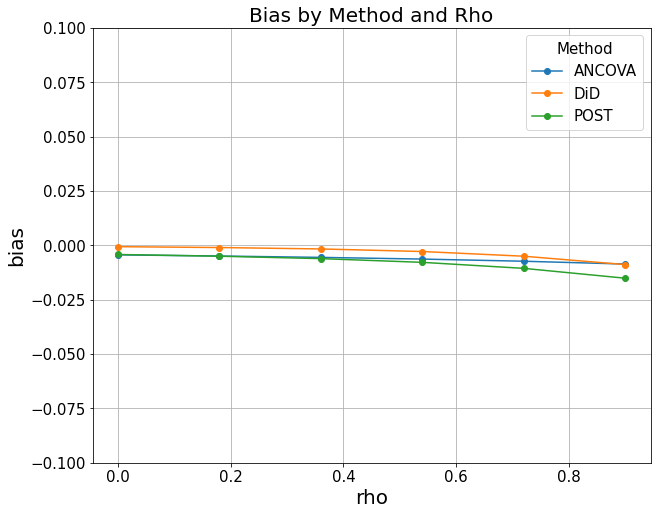

In [50]:
filtered = df_bias.query("method != 'CHANGE'")

fig, ax = plt.subplots(figsize=(10, 8))
for method, grp in filtered.groupby('method'):
    ax = grp.plot(ax=ax, kind='line', x='rho', y='bias', label=method, marker='o', linestyle='-')

plt.ylim(-0.1, 0.1)
plt.legend(title='Method', fontsize=15, title_fontsize=15)
plt.title('Bias by Method and Rho', fontsize=20)
plt.xlabel('rho', fontsize=20)
plt.ylabel('bias', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)

plt.show()

可以看出，无论是DiD、POST还是ANCOVA，估计值与真实值的偏差都很小。

#### （2）计算真实值effect=0.5时，不同rho和估计模型下，所有处理效应估计值（est）的标准差。

In [51]:
df_se = (pivot_long(df_results.query("effect == 0.5"))
         .query("method != 'CHANGE'")
         .groupby(['method', 'rho'])['est']
         .std()
         .reset_index(name='se')
        )

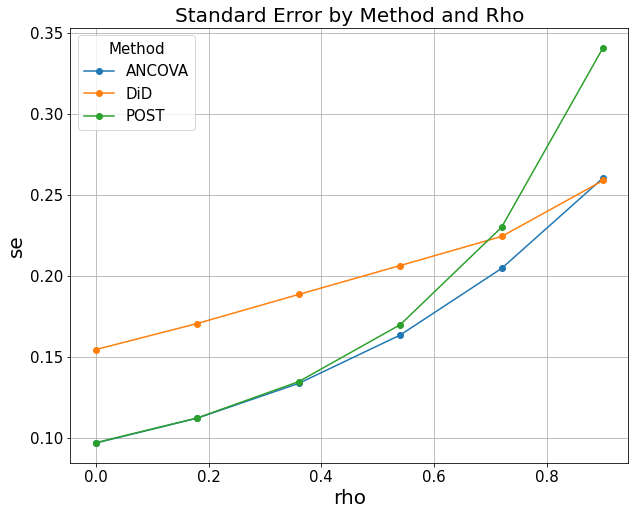

In [52]:
fig, ax = plt.subplots(figsize=(10, 8))
for method, grp in df_se.groupby('method'):
    ax = grp.plot(ax=ax, kind='line', x='rho', y='se', label=method, marker='o', linestyle='-')

plt.legend(title='Method', fontsize=15, title_fontsize=15)
plt.title('Standard Error by Method and Rho', fontsize=20)
plt.xlabel('rho', fontsize=20)
plt.ylabel('se', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)

plt.show()

在响应变量自相关性较弱（rho较小）时，减去处理前响应变量的值（DiD）会增加估计噪声。  
在响应变量自相关性较强（rho较大）时，DiD的会比仅分析处理后的响应变量（POST）更好。  
DiD和POST都没有直接引入前一期的响应变量（ANCOVA）好，而实际上ANCOVA允许在处理前后的响应变量值之间建立更加灵活的，数据驱动的关系。